In [1]:
import pandas as pd
import networkx as nx
import os
import re
from tqdm import tqdm

In [2]:
all_files = []
for dirname, _, filenames in os.walk('/home/francesco/kaggle/input'):
    for filename in filenames:
        full_path=os.path.join(dirname, filename)
        all_files.append(full_path)
files = [file for file in all_files if re.search(r'(((05)(0[1-9]|[12][0-9]|3[01])))', file)]
# files = [file for file in all_files if re.search(r'(FEB|MAR)', file)]
# files = [file for file in all_files if re.search(r'(FEB)', file)]
# files = all_files[:2]
files

['/home/francesco/kaggle/input/20230529_UkraineCombinedTweetsDeduped.csv.gzip',
 '/home/francesco/kaggle/input/20230515_to_20230516_UkraineCombinedTweetsDeduped.csv.gzip',
 '/home/francesco/kaggle/input/20230523_UkraineCombinedTweetsDeduped.csv.gzip',
 '/home/francesco/kaggle/input/20230524_UkraineCombinedTweetsDeduped.csv.gzip',
 '/home/francesco/kaggle/input/20230513_UkraineCombinedTweetsDeduped.csv.gzip',
 '/home/francesco/kaggle/input/20230503_UkraineCombinedTweetsDeduped.csv.gzip',
 '/home/francesco/kaggle/input/20230514_UkraineCombinedTweetsDeduped.csv.gzip',
 '/home/francesco/kaggle/input/20230501_to_20230502_UkraineCombinedTweetsDeduped.csv.gzip',
 '/home/francesco/kaggle/input/20230527_UkraineCombinedTweetsDeduped.csv.gzip',
 '/home/francesco/kaggle/input/20230511_to_20230512_UkraineCombinedTweetsDeduped.csv.gzip',
 '/home/francesco/kaggle/input/20230525_UkraineCombinedTweetsDeduped.csv.gzip',
 '/home/francesco/kaggle/input/20230504_UkraineCombinedTweetsDeduped.csv.gzip',
 '/h

In [3]:
# Reading and Concatenating Multiple Compressed CSV Files into a Single DataFrame
tmp_df_list = []
for file in tqdm(files):
    # print(f"Reading in {file}")
    # unzip and read in the csv file as a dataframe
    tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)
    # append dataframe to temp list
    tmp_df_list.append(tmp_df)

 33%|███▎      | 17/52 [00:06<00:18,  1.92it/s]/tmp/ipykernel_13246/3639286973.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)
 40%|████      | 21/52 [00:07<00:13,  2.23it/s]/tmp/ipykernel_13246/3639286973.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)
 44%|████▍     | 23/52 [00:09<00:17,  1.66it/s]/tmp/ipykernel_13246/3639286973.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(file, compression="gzip", header=0, index_col=0)
 65%|██████▌   | 34/52 [00:43<00:54,  3.03s/it]/tmp/ipykernel_13246/3639286973.py:6: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  tmp_df = pd.read_csv(file, compression

In [4]:
print("Concatenating the DataFrames")
# concatenate the dataframes in the temp list row-wise
data = pd.concat(tmp_df_list, axis=0)
print("Concatenation complete!")

Concatenating the DataFrames
Concatenation complete!


In [5]:
data["usercreatedts"] = pd.to_datetime(data["usercreatedts"], format='mixed')
data["tweetcreatedts"] = pd.to_datetime(data["tweetcreatedts"], format='mixed')
data["extractedts"] = pd.to_datetime(data["extractedts"], format='mixed')
# data['clean_text'] = data['text'].apply(clean_text, emails=True)
# data = data[data["tweetcreatedts"] >= '2022-05-24']
# data = data[data["tweetcreatedts"] < '2022-05-20']
data = data[data['language'] == 'en']
data = data[data["tweetcreatedts"] < '2022-06-01']
data = data[data["tweetcreatedts"] > '2022-04-30']

In [6]:
data.to_csv('tweets.csv')

In [7]:
data.shape

(6133758, 28)

In [10]:

# Create a directed graph
G = nx.DiGraph()

# Add nodes with attributes
for index, row in tqdm(data.iterrows()):
    G.add_node(row['userid'], following=row['following'], 
               followers=row['followers'], totaltweets=row['totaltweets'])

# Add edges for retweets and replies
for index, row in tqdm(data.iterrows()):
    if pd.notna(row['original_tweet_userid']):
        G.add_edge(row['original_tweet_userid'], row['userid'])
    elif pd.notna(row['in_reply_to_user_id']):
        G.add_edge(row['in_reply_to_user_id'], row['userid'])
    elif pd.notna(row['quoted_status_userid']):
        G.add_edge(row['quoted_status_userid'], row['userid'])
    
# Your graph G is now created

6133758it [04:17, 23861.72it/s]
6133758it [04:22, 23334.57it/s]


In [11]:
G.number_of_nodes()

1016028

In [12]:
G.number_of_edges()

2623721

In [14]:
components = list(nx.strongly_connected_components(G))

# Sort components by size
components.sort(key=len, reverse=True)

# # Keep the 10 largest components
# largest_components = components[:10]
# 
# # Create subgraphs for each of the largest components
# largest_subgraphs = [G.subgraph(c).copy() for c in largest_components]

In [28]:
G.subgraph(components[0]).copy().number_of_nodes()

4089

In [15]:
largest_subgraph = G.subgraph(components[0]).copy()

In [17]:
largest_subgraph.number_of_edges()

39120

In [22]:
largest_subgraph.nodes(data=True)

NodeDataView({772211898985095168: {'following': 126, 'followers': 255, 'totaltweets': 4989}, 800222419029852160: {'following': 688, 'followers': 290, 'totaltweets': 939}, 980119931365638144: {'following': 194, 'followers': 244, 'totaltweets': 20224}, 1021190431739084800: {'following': 902, 'followers': 151, 'totaltweets': 66}, 943748968785199104: {'following': 2485, 'followers': 2823, 'totaltweets': 128364}, 973358048738729984: {'following': 772, 'followers': 1638, 'totaltweets': 2618}, 998802618976755712: {'following': 3583, 'followers': 1192, 'totaltweets': 9163}, 1124687555360907264: {'following': 399, 'followers': 1056, 'totaltweets': 11532}, 1114514999748255744: {'following': 133, 'followers': 72, 'totaltweets': 1213}, 1197480887430078464: {'following': 167, 'followers': 630, 'totaltweets': 5295}, 69730304: {'following': 2120, 'followers': 971, 'totaltweets': 145695}, 174145542: {'following': 20700, 'followers': 28480, 'totaltweets': 111225}, 1632821258: {'following': 716, 'follow

In [24]:
# Assuming G is your NetworkX graph
nodes_with_data = largest_subgraph.nodes(data=True)

# Extracting just the names/IDs of the nodes
node_names = [node for node, data in nodes_with_data]

In [30]:
data[data['userid'].isin(node_names)].to_csv('network_tweets.csv')

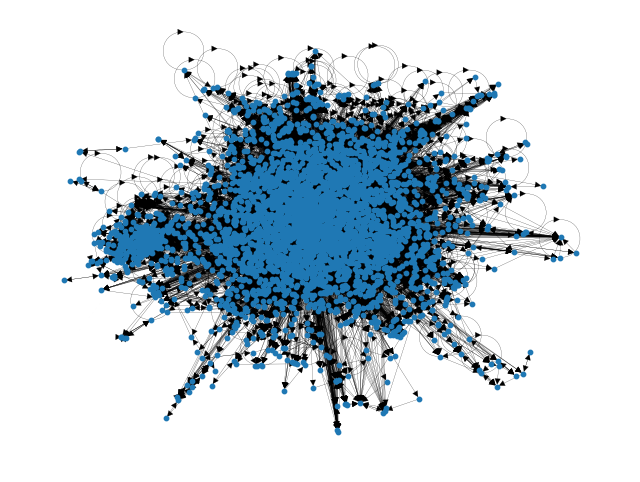

In [23]:
from matplotlib import pyplot as plt

plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}

# Layout the graph using spring layout (you can change the layout method if needed)
pos = nx.spring_layout(largest_subgraph, iterations=20, seed=1721)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Turn off axis labels
ax.axis("off")

# Draw the network
nx.draw_networkx(largest_subgraph, pos=pos, ax=ax, **plot_options)

# Add a title to the plot
# ax.set_title("Original Network")

# Save the plot as an image file (e.g., PNG)
plt.savefig("network.png", format="png", dpi=300, bbox_inches="tight")

# Show the plot (optional, depending on your use case)
plt.show()

In [36]:
eigenvector_centrality = nx.eigenvector_centrality(G, max_iter=1000)

In [37]:
(sorted(eigenvector_centrality.items(), key=lambda item: item[1], reverse=True))[:10]


[(1216550422191587328, 0.15961586082506526),
 (1193634420000993280, 0.15961586082506526),
 (369318439, 0.07986482152028922),
 (1309939958153646081, 0.07983637816796389),
 (1402869817, 0.07983637544505741),
 (2856133189, 0.07980793619574186),
 (397430245, 0.0798079356735406),
 (20848487, 0.07980793489023874),
 (1140725219050577922, 0.07980793418153705),
 (278343846, 0.07980793410693689)]

In [38]:
data[data['userid'] == 369318439]

,userid,username,acctdesc,location,following,followers,totaltweets,usercreatedts,tweetid,tweetcreatedts,...,original_tweet_userid,original_tweet_username,in_reply_to_status_id,in_reply_to_user_id,in_reply_to_screen_name,is_quote_status,quoted_status_id,quoted_status_userid,quoted_status_username,extractedts
8074,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10149,9231,233579,2011-09-07 04:31:32,1652904969010401280,2023-05-01 05:17:08,...,34312259,holmescnn,0,0,NaN,False,0,0,NaN,2023-05-01 08:35:32.577117
13852,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10149,9232,233611,2011-09-07 04:31:32,1652992356495376386,2023-05-01 11:04:23,...,1505860122568011776,Azovsouth,0,0,NaN,False,0,0,NaN,2023-05-01 13:20:55.768788
22560,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10155,9231,233646,2011-09-07 04:31:32,1653105092126466075,2023-05-01 18:32:21,...,1216550422191587328,HerryNapit,0,0,NaN,True,1652989723307315200,0,NaN,2023-05-01 21:06:35.848373
29299,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10155,9231,233723,2011-09-07 04:31:32,1653234118077952000,2023-05-02 03:05:04,...,19536434,igorsushko,0,0,NaN,False,0,0,NaN,2023-05-02 07:07:22.616689
29318,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10155,9231,233723,2011-09-07 04:31:32,1653234633062993922,2023-05-02 03:07:06,...,71298686,TheStudyofWar,0,0,NaN,False,0,0,NaN,2023-05-02 07:07:22.482648
30261,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10155,9231,233723,2011-09-07 04:31:32,1653259276268232704,2023-05-02 04:45:02,...,383249814,gonchar4,0,0,NaN,False,0,0,NaN,2023-05-02 08:22:30.638180
39317,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10155,9231,233741,2011-09-07 04:31:32,1653397711578714115,2023-05-02 13:55:07,...,1595238230995062784,jmss77192137,0,0,NaN,False,0,0,NaN,2023-05-02 16:23:12.166074
49050,369318439,olfashdeb,For the underdog..I have your back #Autism #Ju...,Telegram: @olfashdeb,10155,9230,233800,2011-09-07 04:31:32,1653529968876347393,2023-05-02 22:40:40,...,1519416478864400384,PStyle0ne1,0,0,NaN,False,0,0,NaN,2023-05-03 02:53:56.011521


In [39]:
nx.average_clustering(G)

0.0033647196825821644

In [40]:
colors = ["" for x in range(G.number_of_nodes())]  # initialize colors list
colors = []
counter = 0
for com in nx.community.label_propagation_communities(G):
    color = "#%06X" % randint(0, 0xFFFFFF)  # creates random RGB color
    counter += 1
    for node in list(
        com
    ):  # fill colors list with the particular color for the community nodes
        # colors[node] = color
        colors.append(color)
counter

NetworkXNotImplemented: not implemented for directed type